# Dual-sPLS Modeling and Visualization

This notebook demonstrates data loading, inspection, and several modeling techniques using the **dual_spls** package. We show how to compare predictions and performance metrics for different regression models (PLS, LASSO, Ridge, GL, ElasticNet) on full data and on a calibration/validation split. Visualizations are grouped to allow side‐by‐side comparisons, with improved aesthetics including subplots, legends, and grid lines.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import functions from the dual_spls package
from dual_spls.pls import d_spls_pls
from dual_spls.lasso import d_spls_lasso
from dual_spls.calval import d_spls_calval
from dual_spls.ridge import d_spls_ridge
from dual_spls.GL import d_spls_GL, cluster_variables_fixed_groups
from dual_spls.elasticnet import d_spls_elasticnet_mm
from dual_spls.predict import d_spls_predict
from dual_spls.metric import d_spls_metric
from dual_spls.plot import d_spls_plot  # Optional plotting helper

sns.set(style='whitegrid')  # Set a clean seaborn style
plt.rcParams.update({'font.size': 12, 'figure.figsize': (8, 5)})

## Data Loading

We load the various CSV files containing the NIR spectrum data, derivative spectra, and the response variable. Adjust the file paths as required.

In [2]:
data_dir = "."  
file_X           = os.path.join(data_dir, "matrixXNirSpectrumData.csv")
file_X_axis      = os.path.join(data_dir, "matrixXNirSpectrumDataAxis.csv")
file_deriv       = os.path.join(data_dir, "matrixXNirSpectrumDerivative.csv")
file_deriv_axis  = os.path.join(data_dir, "matrixXNirSpectrumDerivativeAxis.csv")
file_y           = os.path.join(data_dir, "matrixYNirPropertyDensityNormalized.csv")

try:
    X            = np.loadtxt(file_X, delimiter=',').T
    X_axis       = np.loadtxt(file_X_axis, delimiter=',').T
    X_deriv      = np.loadtxt(file_deriv, delimiter=',').T
    X_deriv_axis = np.loadtxt(file_deriv_axis, delimiter=',').T
    y            = np.loadtxt(file_y, delimiter=',').T
except Exception as e:
    print("Error loading files:", e)

print(f"X: {X.shape}, X_axis: {X_axis.shape}, X_deriv: {X_deriv.shape}, \
X_deriv_axis: {X_deriv_axis.shape}, y: {y.shape}")

X: (208, 2635), X_axis: (2635,), X_deriv: (208, 2594), X_deriv_axis: (2594,), y: (208,)


## Data Inspection and Visualization

We first compute a correlation heatmap of the concatenated data (X and y) and then display the response spectrum. The plots below are presented side by side for quick comparison.

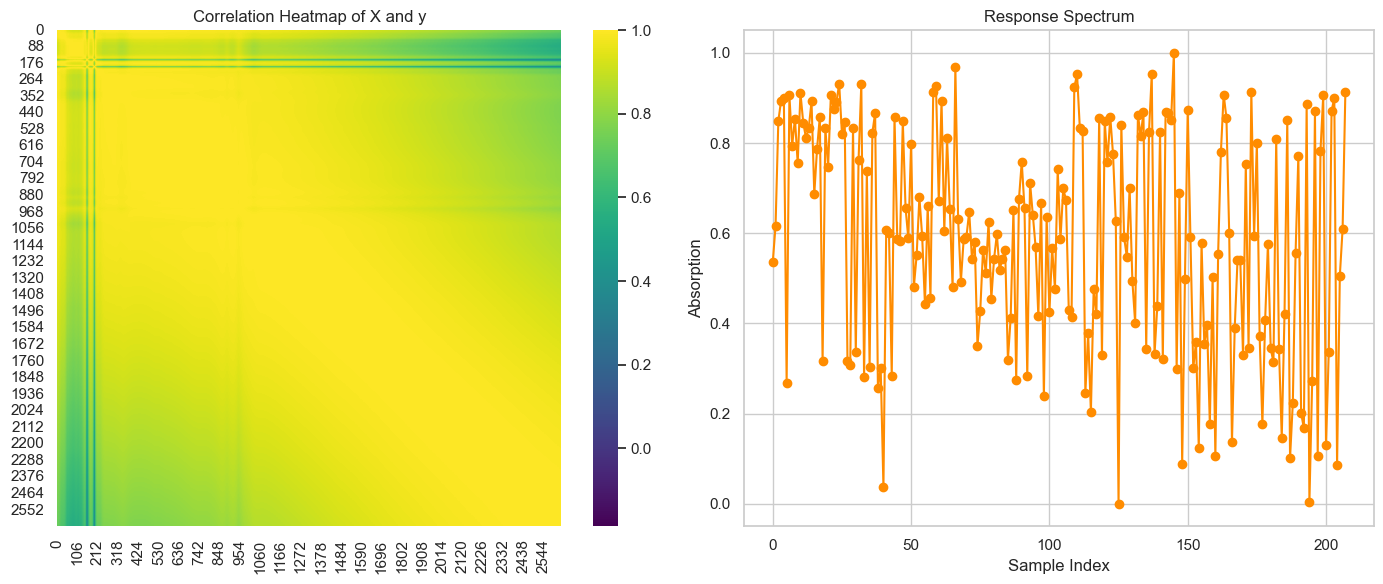

NaNs in y: 0 | NaNs in X: 0


In [3]:
# Combine X and y for correlation analysis
Z = np.concatenate((X, y[:, None]), axis=1)

# Create a figure with two subplots: one for the heatmap and one for the response plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Correlation heatmap
corr = np.corrcoef(Z.T)
sns.heatmap(corr, ax=axes[0], cmap='viridis')
axes[0].set_title('Correlation Heatmap of X and y')

# Plot for response y
axes[1].plot(y, marker='o', linestyle='-', color='darkorange')
axes[1].set_title('Response Spectrum')
axes[1].set_xlabel('Sample Index')
axes[1].set_ylabel('Absorption')

plt.tight_layout()
plt.show()

print("NaNs in y:", np.isnan(y).sum(), "| NaNs in X:", np.isnan(X).sum())

## Full Data Modeling: PLS and LASSO

We now fit two models on the full dataset: a PLS model and a LASSO model. The subplots below compare the fitted values to the actual response.

PLS ic=1 mu=459.9024
PLS ic=2 mu=49.4990
PLS ic=3 mu=12.3965
PLS ic=4 mu=1.2408
PLS ic=5 mu=0.3761
PLS ic=6 mu=0.1513
PLS ic=7 mu=0.1034
PLS ic=8 mu=0.0695
PLS ic=9 mu=0.0189
PLS ic=10 mu=0.0166
PLS model type: pls
Intercept: [0.45430802 0.6449452  2.92609102 2.29467362 3.59486131 4.30131171
 4.52852854 3.93449909 3.97516609 2.97835904]
Bhat shape: (2635, 10)
Dual PLS ic=1, lambda=0.0639, mu=149.8045, nu=9.5707, nbzeros=1844
Dual PLS ic=2, lambda=0.0982, mu=9.9543, nu=0.9779, nbzeros=1053
Dual PLS ic=3, lambda=0.1573, mu=3.9094, nu=0.6151, nbzeros=423
Dual PLS ic=4, lambda=0.1939, mu=0.2300, nu=0.0446, nbzeros=46
Dual PLS ic=5, lambda=0.0209, mu=0.2863, nu=0.0060, nbzeros=4
LASSO model type: lasso
Intercept: [0.45448831 1.20673946 2.84104224 1.94853512 2.53855126]
Bhat shape: (2635, 5)


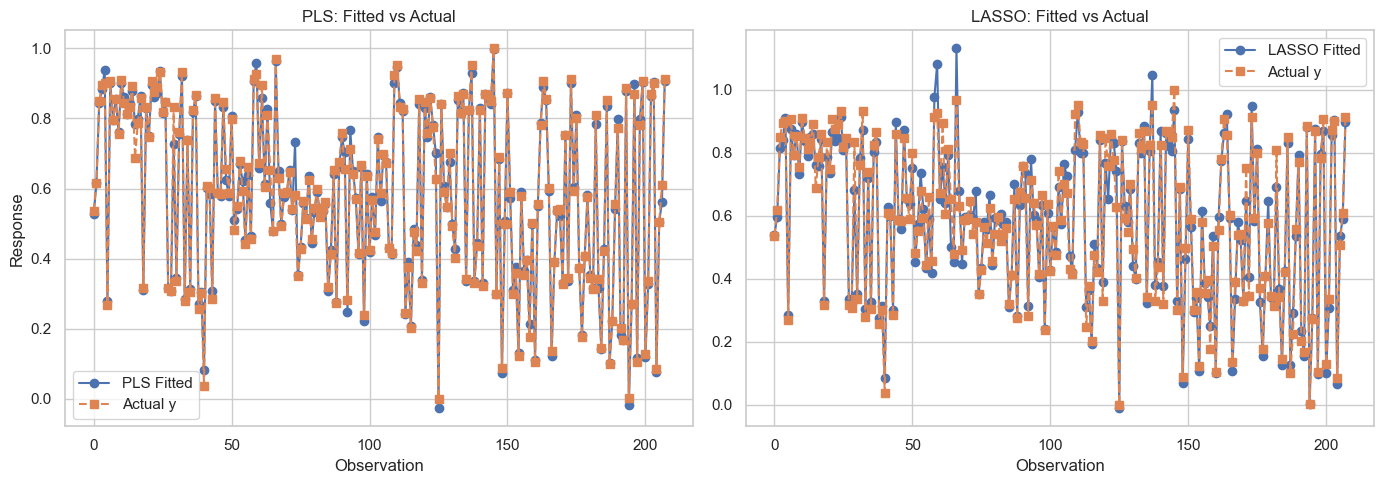

In [4]:
# PLS Model
ncp = 10
model_pls = d_spls_pls(X, y, ncp=ncp, verbose=True)
print("PLS model type:", model_pls.get('type', 'unknown'))
print("Intercept:", model_pls['intercept'])
print("Bhat shape:", model_pls['Bhat'].shape)

# LASSO Model
model_lasso = d_spls_lasso(X, y, ncp=5, ppnu=0.7, verbose=True)
print("LASSO model type:", model_lasso.get('type', 'unknown'))
print("Intercept:", model_lasso['intercept'])
print("Bhat shape:", model_lasso['Bhat'].shape)

# Create subplots for comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# PLS fitted vs actual
axes[0].plot(model_pls['fitted_values'][:, -1], label='PLS Fitted', marker='o')
axes[0].plot(y, label='Actual y', marker='s', linestyle='--')
axes[0].set_title('PLS: Fitted vs Actual')
axes[0].set_xlabel('Observation')
axes[0].set_ylabel('Response')
axes[0].legend()

# LASSO fitted vs actual
axes[1].plot(model_lasso['fitted_values'].T[-1], label='LASSO Fitted', marker='o')
axes[1].plot(y, label='Actual y', marker='s', linestyle='--')
axes[1].set_title('LASSO: Fitted vs Actual')
axes[1].set_xlabel('Observation')
axes[1].legend()

plt.tight_layout()
plt.show()

## Calibration / Validation Split

We now split the full data into calibration and validation sets using the provided function.

In [5]:
ind = d_spls_calval(X, pcal=70, y=y, method="pca_euclidean", pc=0.9)
X_cal, X_val = X[ind['indcal'], :], X[ind['indval'], :]
y_cal, y_val = y[ind['indcal']], y[ind['indval']]
print("Calibration y shape:", y_cal.shape)

Calibration y shape: (145,)


## Calibration Data Modeling: LASSO

Here we fit a LASSO model on the calibration data. The following subplots show:

- **Top:** Fitted values on calibration data vs. the observed response.
- **Middle:** Predictions on the validation set compared to actual validation responses.
- **Bottom:** Performance metrics (MSE and R²) for the model on the validation set.

Dual PLS ic=1, lambda=0.4207, mu=29.5362, nu=12.4264, nbzeros=2372
Dual PLS ic=2, lambda=0.1287, mu=5.2141, nu=0.6709, nbzeros=2109
Dual PLS ic=3, lambda=0.3166, mu=1.8723, nu=0.5928, nbzeros=1846
Cal LASSO model type: lasso
Intercept: [0.44925624 1.12275455 2.90901598]
Bhat shape: (2635, 3)


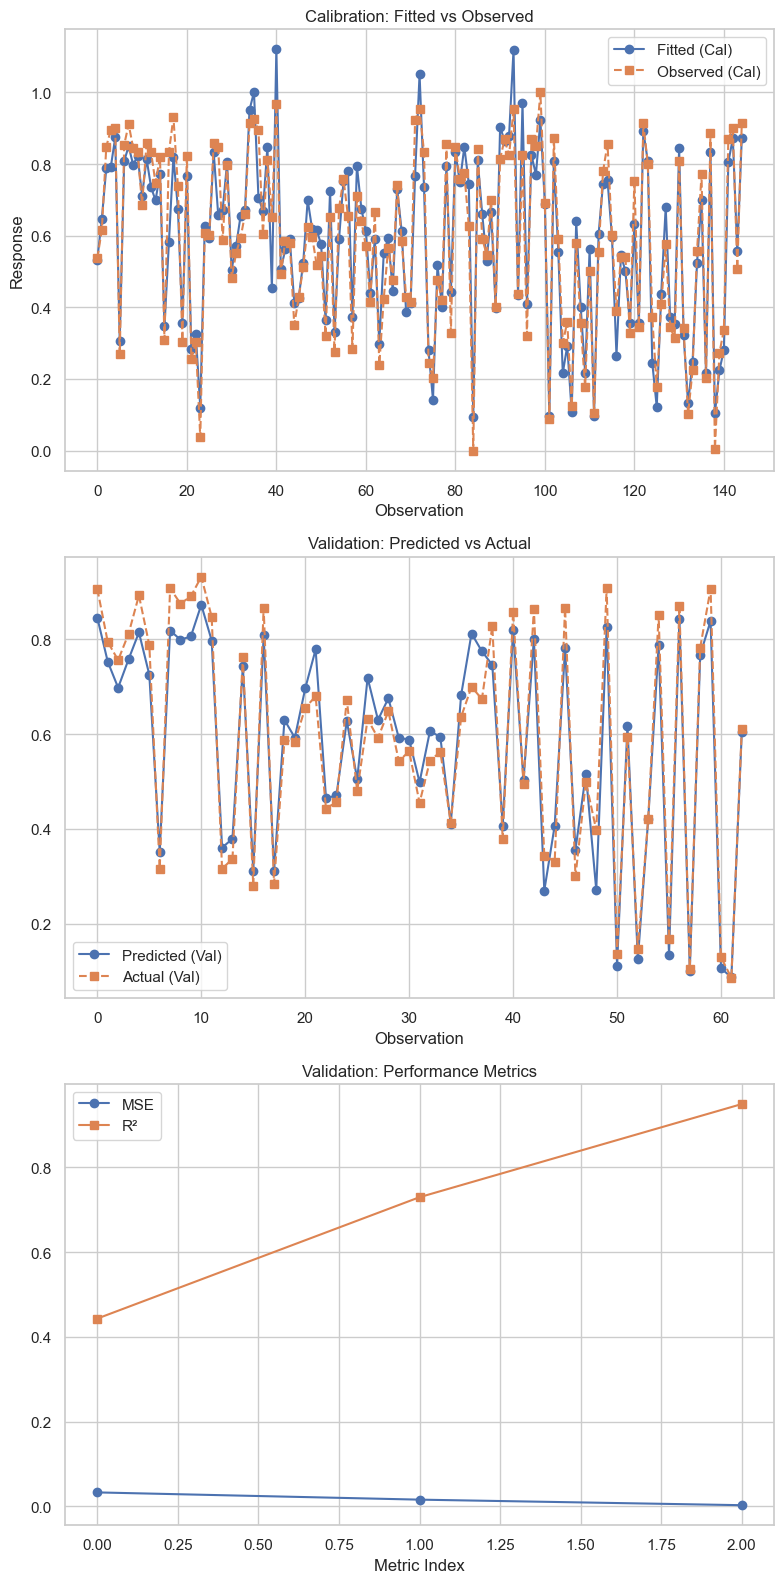

In [6]:
# Fit LASSO model on calibration data
model_lasso_cal = d_spls_lasso(X_cal, y_cal, ncp=3, ppnu=0.9, verbose=True)
print("Cal LASSO model type:", model_lasso_cal.get('type', 'unknown'))
print("Intercept:", model_lasso_cal['intercept'])
print("Bhat shape:", model_lasso_cal['Bhat'].shape)

fig, axes = plt.subplots(3, 1, figsize=(8, 16))

# Top: Fitted vs observed on calibration
axes[0].plot(model_lasso_cal['fitted_values'].T[-1], label='Fitted (Cal)', marker='o')
axes[0].plot(y_cal, label='Observed (Cal)', marker='s', linestyle='--')
axes[0].set_title('Calibration: Fitted vs Observed')
axes[0].set_xlabel('Observation')
axes[0].set_ylabel('Response')
axes[0].legend()

# Middle: Predicted on validation
y_new = d_spls_predict(model_lasso_cal, X_val).T[-1]
axes[1].plot(y_new, label='Predicted (Val)', marker='o')
axes[1].plot(y_val, label='Actual (Val)', marker='s', linestyle='--')
axes[1].set_title('Validation: Predicted vs Actual')
axes[1].set_xlabel('Observation')
axes[1].legend()

# Bottom: Performance Metrics
metrics = d_spls_metric(model_lasso_cal, X_val, y_val)
axes[2].plot(metrics['MSE'], label='MSE', marker='o')
axes[2].plot(metrics['R2'], label='R²', marker='s')
axes[2].set_title('Validation: Performance Metrics')
axes[2].set_xlabel('Metric Index')
axes[2].legend()

plt.tight_layout()
plt.show()

## Calibration Data Modeling: Ridge

Now we fit a Ridge model on the calibration data and compare calibration fitted values and validation predictions.

Ridge: Component 1 computed.
Ridge: Component 2 computed.
Ridge: Component 3 computed.
Ridge: Component 4 computed.
Ridge: Component 5 computed.
Ridge: Component 6 computed.
Ridge: Component 7 computed.
Ridge: Component 8 computed.
Ridge: Component 9 computed.
Ridge: Component 10 computed.
Ridge model type: ridge
Intercept: [0.58772568 1.03119617 2.57076166 2.57076166 2.57076166 2.57076166
 2.57076166 2.57076166 2.57076166 2.57076166]
Bhat shape: (2635, 10)


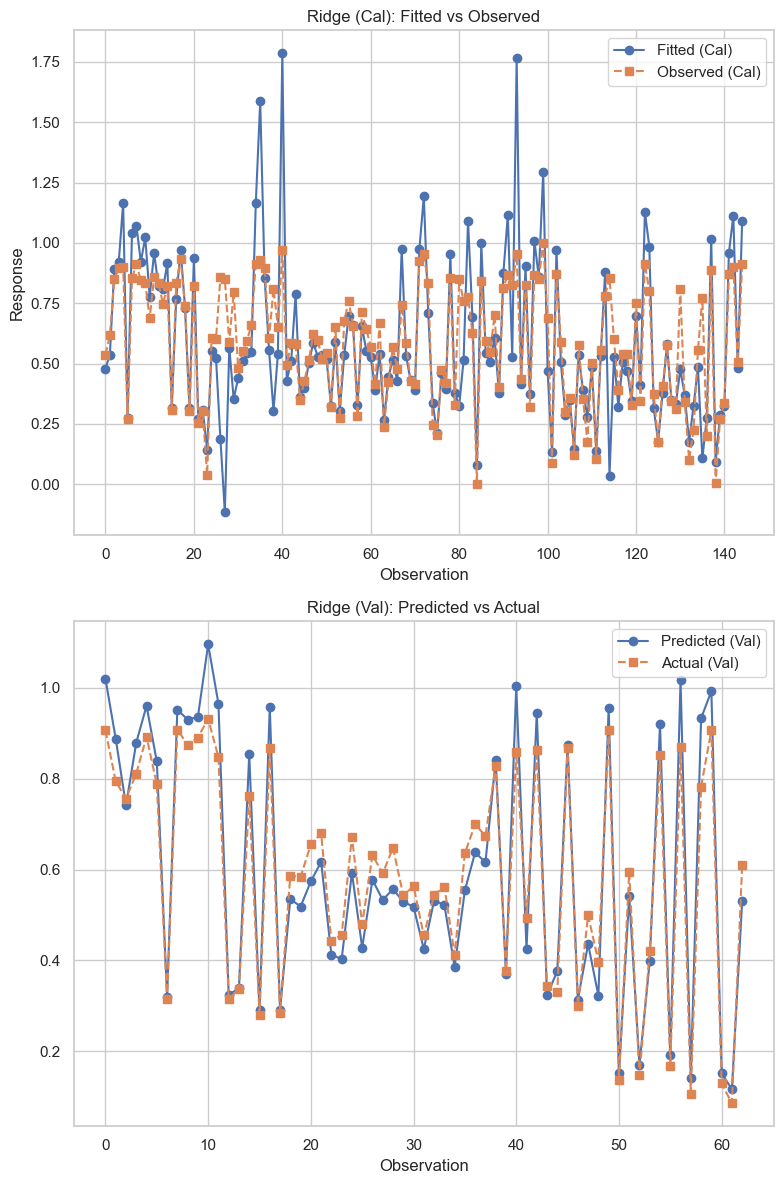

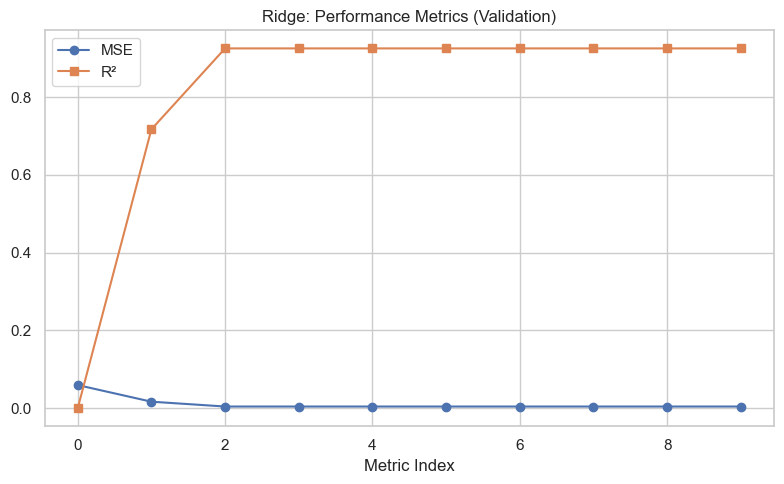

In [7]:
# Fit Ridge model on calibration data
model_ridge = d_spls_ridge(X_cal, y_cal, ncp=10, ppnu=0.7, verbose=True)
print("Ridge model type:", model_ridge.get('type', 'unknown'))
print("Intercept:", model_ridge['intercept'])
print("Bhat shape:", model_ridge['Bhat'].shape)

fig, axes = plt.subplots(2, 1, figsize=(8, 12))

# Top: Calibration fitted vs observed
axes[0].plot(model_ridge['fitted_values'].T[-1], label='Fitted (Cal)', marker='o')
axes[0].plot(y_cal, label='Observed (Cal)', marker='s', linestyle='--')
axes[0].set_title('Ridge (Cal): Fitted vs Observed')
axes[0].set_xlabel('Observation')
axes[0].set_ylabel('Response')
axes[0].legend()

# Bottom: Validation predictions
y_new = d_spls_predict(model_ridge, X_val).T[-1]
axes[1].plot(y_new, label='Predicted (Val)', marker='o')
axes[1].plot(y_val, label='Actual (Val)', marker='s', linestyle='--')
axes[1].set_title('Ridge (Val): Predicted vs Actual')
axes[1].set_xlabel('Observation')
axes[1].legend()

plt.tight_layout()
plt.show();

# Performance metrics for Ridge
metrics = d_spls_metric(model_ridge, X_val, y_val)
plt.figure(figsize=(8, 5))
plt.plot(metrics['MSE'], label='MSE', marker='o')
plt.plot(metrics['R2'], label='R²', marker='s')
plt.title('Ridge: Performance Metrics (Validation)')
plt.xlabel('Metric Index')
plt.legend()
plt.tight_layout()
plt.show();

## Calibration Data Modeling: GL Model with Variable Clustering

The GL model groups variables via clustering (using a Ward method) and fits a model on the calibration data. In addition to fitted and predicted comparisons, we plot the regression coefficients and compute the sparsity ratio.

Dual PLS ic = 1 | lambda = [7.55495338 4.30983439 3.40775424 4.20878692 2.74643944] | mu = 7.494990744377025 | nu = [15.10319511 10.46219022  1.22672909  6.10897705  3.45200021] | nbzeros = [353 640 144 625 834]
Dual PLS ic = 2 | lambda = [ 1.77505159  7.47369187  1.94170115 22.73351624  0.58632709] | mu = 2.1301501737344566 | nu = [0.36667117 0.62080068 1.36703464 0.63249382 0.65003406] | nbzeros = [353 640 130 625 834]
Dual PLS ic = 3 | lambda = [4.92686274 4.70568192 3.02217443 1.5245379  1.28200255] | mu = 1.5626950307342198 | nu = [0.3022403  0.65438074 0.44726766 0.87052959 0.82468711] | nbzeros = [353 640 130 625 751]
Dual PLS ic = 4 | lambda = [14.73646021 25.90305926  2.92028501  7.62161053  0.65902153] | mu = 0.10485838999169944 | nu = [0.06146349 0.07791595 0.04281296 0.07162688 0.04851793] | nbzeros = [314 640 116 625 751]
Dual PLS ic = 5 | lambda = [ 0.32068742  1.00860531  2.56657641 36.15627051  0.82145565] | mu = 0.04093311773574318 | nu = [0.00203346 0.00690478 0.02839

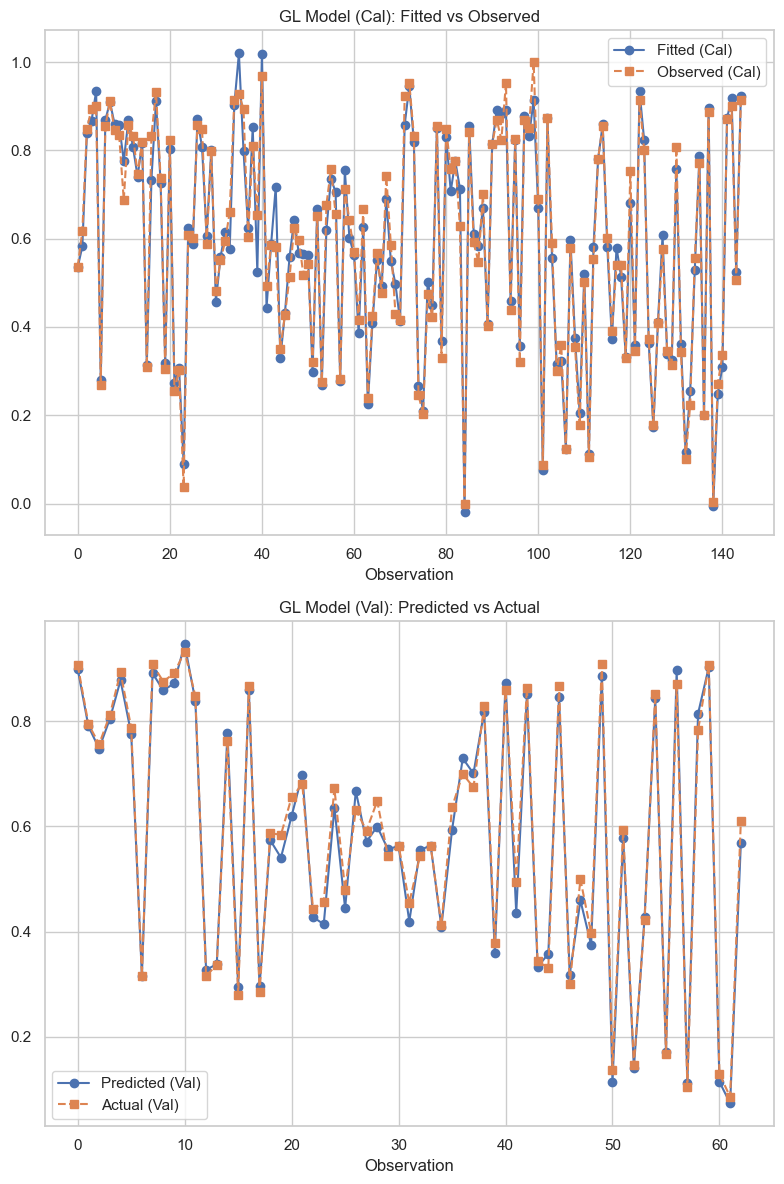

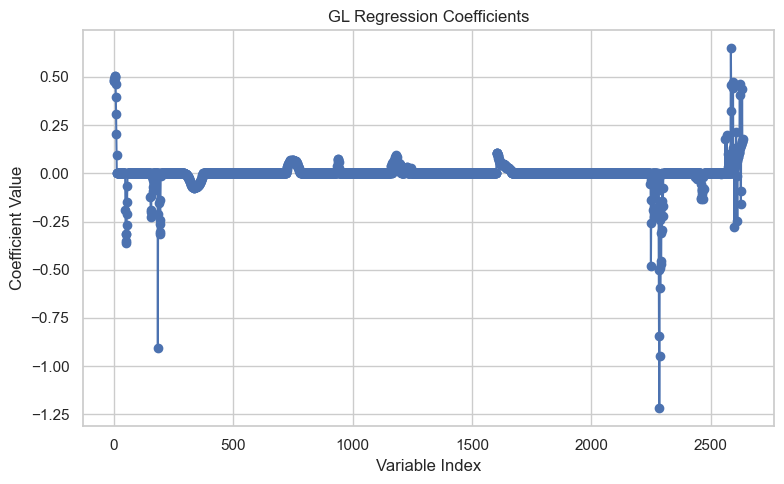

GL sparsity ratio: 0.1616698292220114


In [8]:
indG = cluster_variables_fixed_groups(X_cal, method='ward', n_groups=5)
model_GL = d_spls_GL(X_cal, y_cal, ncp=5, ppnu=0.9, indG=indG, verbose=True)
print("GL model type:", model_GL.get('type', 'unknown'))
print("Intercept:", model_GL['intercept'])
print(f"Bhat shape: {model_GL['Bhat'].shape} | Number of Groups: {len(indG)}")

fig, axes = plt.subplots(2, 1, figsize=(8, 12))

# Top: Calibration fitted vs observed for GL
axes[0].plot(model_GL['fitted_values'].T[-1], label='Fitted (Cal)', marker='o')
axes[0].plot(y_cal, label='Observed (Cal)', marker='s', linestyle='--')
axes[0].set_title('GL Model (Cal): Fitted vs Observed')
axes[0].set_xlabel('Observation')
axes[0].legend()

# Bottom: Validation predictions for GL
y_new = d_spls_predict(model_GL, X_val).T[-1]
axes[1].plot(y_new, label='Predicted (Val)', marker='o')
axes[1].plot(y_val, label='Actual (Val)', marker='s', linestyle='--')
axes[1].set_title('GL Model (Val): Predicted vs Actual')
axes[1].set_xlabel('Observation')
axes[1].legend()

plt.tight_layout()
plt.show();

# Plot GL regression coefficients and compute sparsity
B = model_GL['Bhat']
sprsty = B.T[-1]
ratio_sprs = np.count_nonzero(sprsty) / len(sprsty)

plt.figure(figsize=(8, 5))
plt.plot(sprsty, marker='o', linestyle='-')
plt.title('GL Regression Coefficients')
plt.xlabel('Variable Index')
plt.ylabel('Coefficient Value')
plt.tight_layout()
plt.show()
print("GL sparsity ratio:", ratio_sprs)

## Calibration Data Modeling: Elastic Net

Finally, we fit an Elastic Net model (using dual_spls elasticnet) on the calibration data. We then compare fitted versus observed values and show the performance metrics as well as the sparsity of the solution.

[MM Dual-sPLS EN] Component 1, Dual norm = 0.0000
[MM Dual-sPLS EN] Component 2, Dual norm = 0.0000
[MM Dual-sPLS EN] Component 3, Dual norm = 0.0000
[MM Dual-sPLS EN] Component 4, Dual norm = 0.0000
[MM Dual-sPLS EN] Component 5, Dual norm = 0.0000
[MM Dual-sPLS EN] Component 6, Dual norm = 0.0000
[MM Dual-sPLS EN] Component 7, Dual norm = 0.0000
[MM Dual-sPLS EN] Component 8, Dual norm = 0.0000
[MM Dual-sPLS EN] Component 9, Dual norm = 0.0000
[MM Dual-sPLS EN] Component 10, Dual norm = 0.0000
ElasticNet model type: elasticnet-mm
Intercept: [0.448909   1.35875431 2.93513342 2.0835325  2.29698307 2.74254101
 2.3360002  3.24288563 3.46832837 3.72369551]
Bhat shape: (2635, 10)


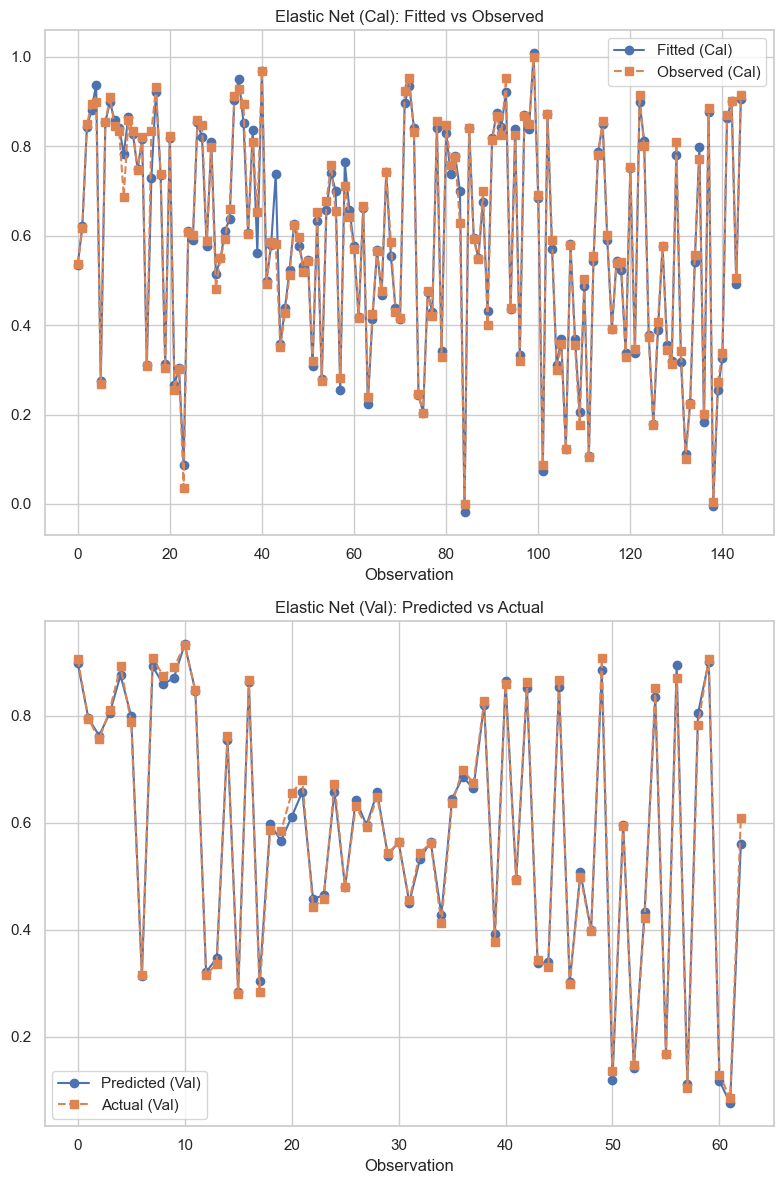

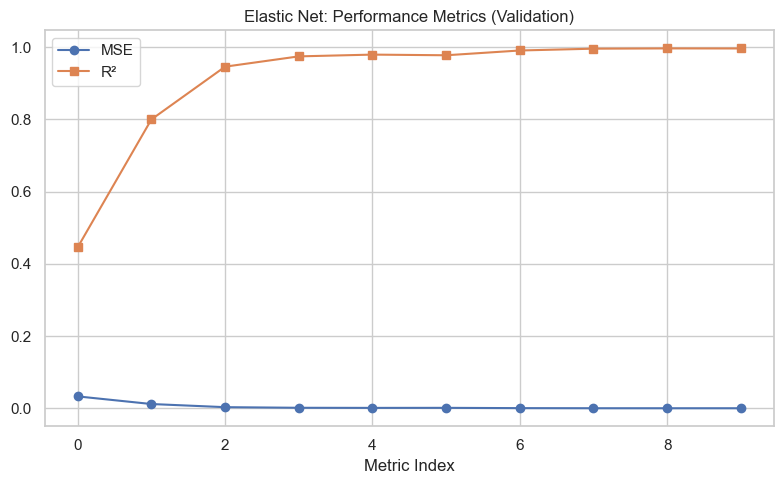

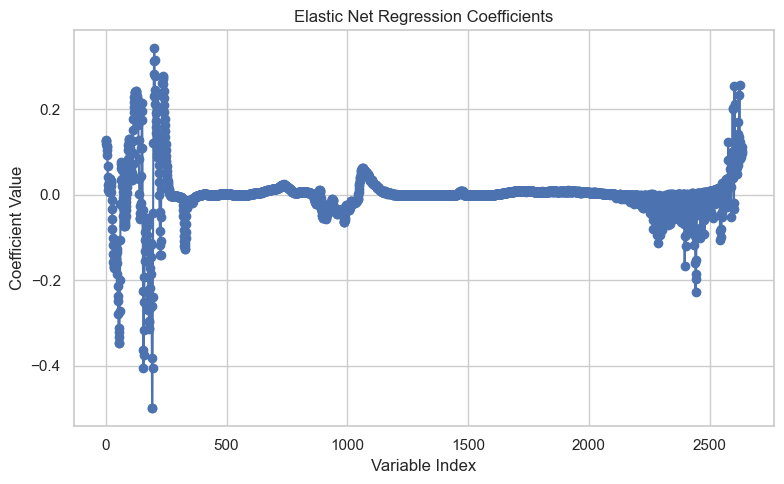

Elastic Net sparsity ratio: 0.9248576850094876


In [ ]:
# Fit Elastic Net model on calibration data
model_en = d_spls_elasticnet_mm(X_cal, y_cal, ncp=10, verbose=True)
print("ElasticNet model type:", model_en.get('type', 'unknown'))
print("Intercept:", model_en['intercept'])
print("Bhat shape:", model_en['Bhat'].shape)

fig, axes = plt.subplots(2, 1, figsize=(8, 12))

# Top: Calibration fitted vs observed for Elastic Net
axes[0].plot(model_en['fitted_values'].T[-1], label='Fitted (Cal)', marker='o')
axes[0].plot(y_cal, label='Observed (Cal)', marker='s', linestyle='--')
axes[0].set_title('Elastic Net (Cal): Fitted vs Observed')
axes[0].set_xlabel('Observation')
axes[0].legend()

# Bottom: Validation predictions for Elastic Net
y_new = d_spls_predict(model_en, X_val).T[-1]
axes[1].plot(y_new, label='Predicted (Val)', marker='o')
axes[1].plot(y_val, label='Actual (Val)', marker='s', linestyle='--')
axes[1].set_title('Elastic Net (Val): Predicted vs Actual')
axes[1].set_xlabel('Observation')
axes[1].legend()

plt.tight_layout()
plt.show()

# Performance metrics and sparsity for Elastic Net
metrics = d_spls_metric(model_en, X_val, y_val)
plt.figure(figsize=(8, 5))
plt.plot(metrics['MSE'], label='MSE', marker='o')
plt.plot(metrics['R2'], label='R²', marker='s')
plt.title('Elastic Net: Performance Metrics (Validation)')
plt.xlabel('Metric Index')
plt.legend()
plt.tight_layout()
plt.show()

B = model_en['Bhat']
sprsty = B.T[-1]
ratio_sprs_en = np.count_nonzero(sprsty) / len(sprsty)

plt.figure(figsize=(8, 5))
plt.plot(sprsty, marker='o', linestyle='-')
plt.title('Elastic Net Regression Coefficients')
plt.xlabel('Variable Index')
plt.ylabel('Coefficient Value')
plt.tight_layout()
plt.show()
print("Elastic Net sparsity ratio:", ratio_sprs_en)